In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from Notebooks.TitanicFunctions import *
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

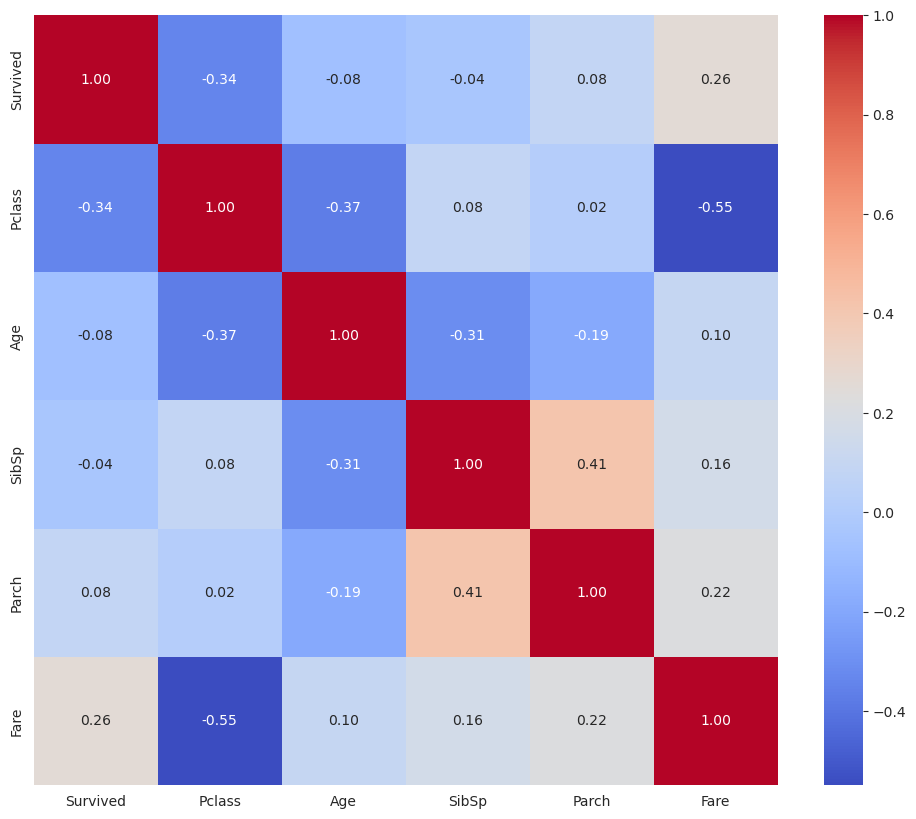

In [7]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.pop('PassengerId')
ids = test.pop('PassengerId')

In [3]:
train = preprocess(train)
test = preprocess(test)

/home/abog/UpperDivision/PycharmProjects/Titanic/Notebooks/TitanicFunctions.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
/home/abog/UpperDivision/PycharmProjects/Titanic/Notebooks/TitanicFunctions.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

<function matplotlib.pyplot.show(close=None, block=None)>

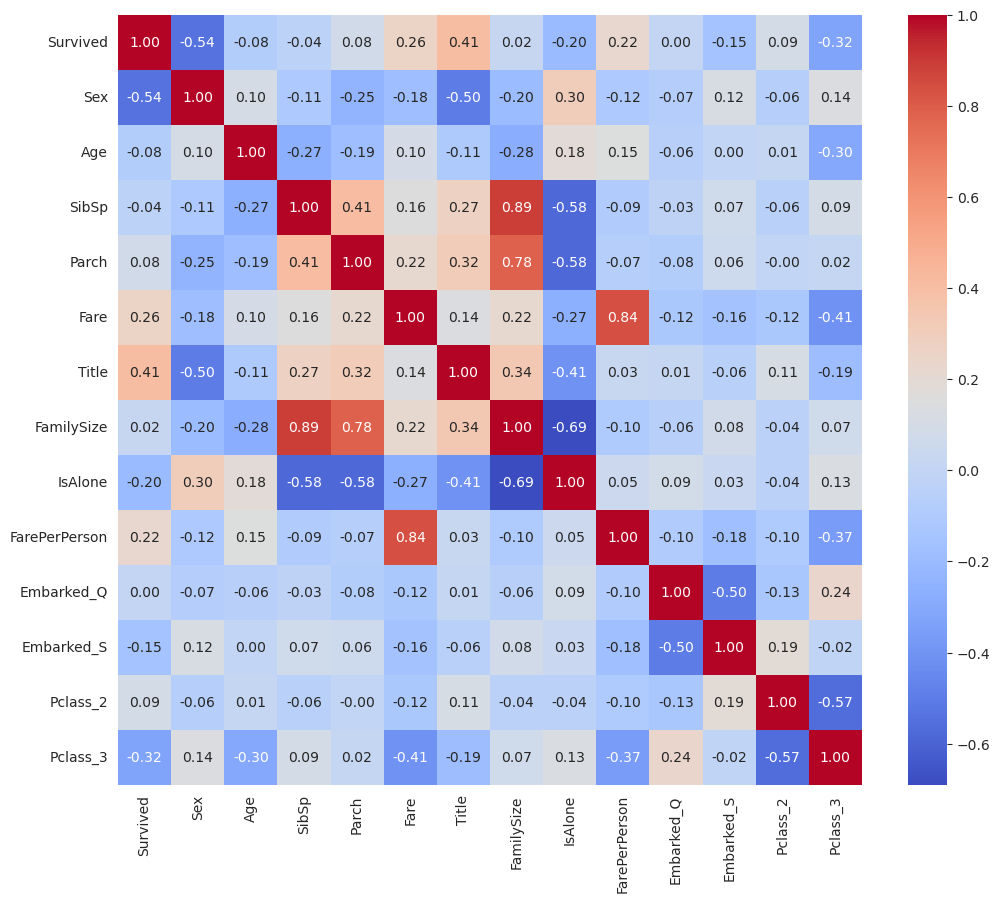

In [4]:
corr_mat = train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_mat, annot=True, fmt=".2f",cmap='coolwarm')
plt.show

In [5]:
x = train
y = train.pop('Survived')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [6]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
        "max_depth": trial.suggest_int('max_depth', 1, 3),
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        "subsample": trial.suggest_float('subsample', 0.5, 0.8),
        "colsample_bytree": trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.6, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.6, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    model = XGBClassifier(**param,
        eval_metric='logloss',
        early_stopping_rounds=5,
        n_jobs = -1,
                          )
    cv_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_train_cv, y_train_cv,eval_set=[(X_valid_cv, y_valid_cv)], verbose=False)
        preds = model.predict(X_valid_cv)
        accuracy = accuracy_score(y_valid_cv, preds)
        cv_scores.append(accuracy)

    mean_cv_score = np.mean(cv_scores)

    return mean_cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
params = study.best_params
print(study.best_trial)

[I 2024-11-26 18:11:13,854] A new study created in memory with name: no-name-10e665ef-2306-4d1d-805c-74e99843bc89
[I 2024-11-26 18:11:14,639] Trial 0 finished with value: 0.6292114695340502 and parameters: {'n_estimators': 193, 'max_depth': 1, 'learning_rate': 0.0016049056288891025, 'subsample': 0.7516206010033513, 'colsample_bytree': 0.7613939982020372, 'min_child_weight': 20, 'gamma': 0.46534069469843536, 'reg_alpha': 0.9767421814539003, 'reg_lambda': 0.7916630384635507, 'scale_pos_weight': 1.1157484512203864, 'max_delta_step': 9}. Best is trial 0 with value: 0.6292114695340502.
[I 2024-11-26 18:11:15,137] Trial 1 finished with value: 0.7897081413210445 and parameters: {'n_estimators': 265, 'max_depth': 2, 'learning_rate': 0.007562562656715388, 'subsample': 0.7833780793682716, 'colsample_bytree': 0.6748588698403302, 'min_child_weight': 13, 'gamma': 0.4286952124315802, 'reg_alpha': 0.610681433757236, 'reg_lambda': 0.9827324070545058, 'scale_pos_weight': 1.499894612173653, 'max_delta_s

FrozenTrial(number=77, state=1, values=[0.8218637992831541], datetime_start=datetime.datetime(2024, 11, 26, 18, 11, 47, 651297), datetime_complete=datetime.datetime(2024, 11, 26, 18, 11, 47, 870839), params={'n_estimators': 825, 'max_depth': 3, 'learning_rate': 0.07920784301116428, 'subsample': 0.784233383479384, 'colsample_bytree': 0.5168214816441236, 'min_child_weight': 10, 'gamma': 0.08922810545175383, 'reg_alpha': 0.9880908645356133, 'reg_lambda': 0.6305812772278351, 'scale_pos_weight': 1.080408667484008, 'max_delta_step': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=3, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'subsample': FloatDistribution(high=0.8, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=0.8, log=False, low=0.5, step=None), 'min_child_weight': IntD

In [7]:
model = XGBClassifier(**params,
        eval_metric='logloss',
        early_stopping_rounds=5,
        n_jobs = -1,)
model.fit(X_train, y_train, eval_set=([(X_test, y_test)]), verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5168214816441236, device=None,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.08922810545175383, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07920784301116428,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=10, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=825, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_sub = model.predict(test)
submission = pd.DataFrame({'PassengerId': ids, 'Survived': y_sub})
submission.to_csv('../submissions/submission.csv', index=False)
print(params)

{'n_estimators': 825, 'max_depth': 3, 'learning_rate': 0.07920784301116428, 'subsample': 0.784233383479384, 'colsample_bytree': 0.5168214816441236, 'min_child_weight': 10, 'gamma': 0.08922810545175383, 'reg_alpha': 0.9880908645356133, 'reg_lambda': 0.6305812772278351, 'scale_pos_weight': 1.080408667484008, 'max_delta_step': 10}


In [9]:
#params77 = pd.DataFrame({'n_estimators': 325, 'max_depth': 5, 'learning_rate': 0.007950632085306823, 'subsample': 0.5997329087568998, 'colsample_bytree': 0.6378564783642813},index=[0])
#params77.to_json('../params/params77.json', orient='records', index=False, indent=4)